# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import re
import librosa   
import pickle
import shutil
import gc

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input, Lambda, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [ ]:
# ns = [f'{x:02d}' for x in range(1,61)]

In [ ]:
# ns = [f'{x:02d}' for x in [32, 40, 41, 43, 42, 44, 15, 16, 17, 18, 19, 20]]

In [ ]:
# y_s = []
# for i, n in enumerate(ns):
#   print(i, end='\t')
#   if (i%10==0) & (i != 0):
#     print('')
#   with open(f'drive/Shareddrives/Ling Thesis/X,y/y/MFCC_y_{n}.pickle', 'rb') as handle:
#     y_s.append(pickle.load(handle))

# y = np.concatenate(y_s)
# del y_s

# # size = sum(y) #Get Number of True Labels (n)
# # indicies = list(np.random.choice(np.where(y == 0)[0], int(size))) #Generate (n) Random False Labels
# # indicies += list(np.where(y == 1)[0]) #Create Balanced Mask

# # y = y[indicies] #Apply Mask to Labels

# with open(f'drive/Shareddrives/Ling Thesis/X,y/Joined/y.pickle', 'wb') as handle:
#   pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

0	1	2	3	4	5	6	7	8	9	10	
11	12	13	14	15	16	17	18	19	20	
21	22	23	24	25	26	27	28	29	30	
31	32	33	34	35	36	37	38	39	40	
41	42	43	44	45	46	47	48	49	50	
51	52	53	54	55	56	57	58	59	

In [ ]:
# sets = ['preboundary','postboundary','boundary']

# for s in sets:
#   print(s)
#   globals()[f'X_{s}_s'] = []

#   for i, n in enumerate(ns):
#     print(i, end='\t')
#     if (i%10==0):
#       print('')
#     with open(f'drive/Shareddrives/Ling Thesis/X,y/X_{s}/{n}.pickle', 'rb') as handle:
#       globals()[f'X_{s}_s'].append(pickle.load(handle))
#   globals()[f'X_{s}'] = np.concatenate(globals()[f'X_{s}_s']).transpose(0,2,1)
#   del globals()[f'X_{s}_s']
#   print('\nwrite')
#   with open(f'drive/Shareddrives/Ling Thesis/X,y/Joined/X_{s}.pickle', 'wb') as handle:
#     pickle.dump(globals()[f'X_{s}'], handle, protocol=pickle.HIGHEST_PROTOCOL)
#   del globals()[f'X_{s}']

preboundary
0	
1	2	3	4	5	6	7	8	9	10	
11	12	13	14	15	16	17	18	19	20	
21	22	23	24	25	26	27	28	29	30	
31	32	33	34	35	36	37	38	39	40	
41	42	43	44	45	46	47	48	49	50	
51	52	53	54	55	56	57	58	59	
write
postboundary
0	
1	2	3	4	5	6	7	8	9	10	
11	12	13	14	15	16	17	18	19	20	
21	22	23	24	25	26	27	28	29	30	
31	32	33	34	35	36	37	38	39	40	
41	42	43	44	45	46	47	48	49	50	
51	52	53	54	55	56	57	58	59	
write
boundary
0	
1	2	3	4	5	6	7	8	9	10	
11	12	13	14	15	16	17	18	19	20	
21	22	23	24	25	26	27	28	29	30	
31	32	33	34	35	36	37	38	39	40	
41	42	43	44	45	46	47	48	49	50	
51	52	53	54	55	56	57	58	59	
write


In [ ]:
sets = ['preboundary','postboundary','boundary']

for s in sets:
  print(s)
  with open(f'drive/Shareddrives/Ling Thesis/X,y/Joined/X_{s}.pickle', 'rb') as handle:
    globals()[f'X_{s}'] = pickle.load(handle)

with open(f'drive/Shareddrives/Ling Thesis/X,y/Joined/y.pickle', 'rb') as handle:
  y = pickle.load(handle)

preboundary
postboundary
boundary


In [ ]:
X_preboundary.shape[0], y.shape[0] #Verify Lengths 164120

(164572, 164572)

In [ ]:
# y = np.clip(np.where(y != 0, np.log(y), 0),0,10)/10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [ ]:
# 1 - np.clip(np.log(50),0,10)/10

0.6087976994571854

In [ ]:
# y = 1-y

In [ ]:
shuffler = np.random.RandomState(seed=42).permutation(len(X_postboundary)) #Generate Shuffle Pattern
train_test_split_index = round(len(y)*.8)

for s in sets:
  globals()[f'X_{s}'] = globals()[f'X_{s}'][shuffler] #Shuffle Features
  globals()[f'X_{s}_train'] = globals()[f'X_{s}'][:train_test_split_index]
  globals()[f'X_{s}_test'] = globals()[f'X_{s}'][train_test_split_index:]
y = y[shuffler] #... and labels
y_train = y[:train_test_split_index]
y_test = y[train_test_split_index:]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) #Seperate Train/Test Data

# RNN

In [ ]:
def rnn_model(s):
  path = f'drive/Shareddrives/Ling Thesis/rnn_checkpoints_{s}'
  print(path)
  try:
    os.mkdir(path)
  except:
    shutil.rmtree(path)
    os.mkdir(path)
  checkpoint_rnn = ModelCheckpoint(f'{path}/{s}'+'_rnn-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

  rnn_model = Sequential()
  rnn_model.add(LSTM(64, return_sequences=True, recurrent_dropout=0,dropout=0.2,recurrent_activation='sigmoid'))
  rnn_model.add(LSTM(48, return_sequences=False, dropout=0.2, recurrent_dropout=0,recurrent_activation='sigmoid'))
  # rnn_model.add(Dense(8, activation='tanh'))
  # rnn_model.add(Dropout(.2))
  rnn_model.add(Dense(1, activation='sigmoid'))

  rnn_model.compile(optimizer='adam', loss='MSE')
  rnn_model.fit(globals()[f'X_{s}_train'],  y_train, batch_size=512, epochs=35, callbacks=[checkpoint_rnn], validation_split=0.15, shuffle=True)

In [ ]:
for s in sets[:-1]:
  tf.keras.backend.clear_session() #.21222
  gc.collect()
  rnn_model(s)

drive/Shareddrives/Ling Thesis/rnn_checkpoints_preboundary
Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 0.2339
Epoch 1: val_loss improved from inf to 0.22428, saving model to drive/Shareddrives/Ling Thesis/rnn_checkpoints_preboundary/preboundary_rnn-001-0.233860-0.224280.h5
219/219 [==============================] - 31s 95ms/step - loss: 0.2339 - val_loss: 0.2243
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 0.2247
Epoch 2: val_loss improved from 0.22428 to 0.22255, saving model to drive/Shareddrives/Ling Thesis/rnn_checkpoints_preboundary/preboundary_rnn-002-0.224673-0.222552.h5
219/219 [==============================] - 19s 89ms/step - loss: 0.2247 - val_loss: 0.2226
Epoch 3/35
219/219 [==============================] - ETA: 0s - loss: 0.2224
Epoch 3: val_loss improved from 0.22255 to 0.22024, saving model to drive/Shareddrives/Ling Thesis/rnn_checkpoints_preboundary/preboundary_rnn-003-0.222362-0.220241.h5
219/219 [===================

# CNN

In [ ]:
def cnn_model(s):
  path = f'drive/Shareddrives/Ling Thesis/cnn_checkpoints_{s}_wider'
  print(path)
  try:
    os.mkdir(path)
  except:
    shutil.rmtree(path)
    os.mkdir(path)
  checkpoint_cnn = ModelCheckpoint(f'{path}/{s}'+'_cnn-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

  cnn_model = Sequential()
  cnn_model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation ="relu"))
  cnn_model.add(MaxPooling2D((2,2), padding='same'))
  cnn_model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
  cnn_model.add(MaxPooling2D((2,2), padding='same'))
  cnn_model.add(Flatten())
  cnn_model.add(Dropout(.2))
  cnn_model.add(Dense(64, activation='tanh'))
  cnn_model.add(Dropout(.2))
  cnn_model.add(Dense(32, activation='tanh'))
  cnn_model.add(Dropout(.2))
  cnn_model.add(Dense(1, activation='sigmoid'))

  cnn_model.compile(optimizer='adam', loss='MSE')
  if s == 'boundary':
    xx = np.expand_dims(globals()[f'X_{s}_train'][:,100:212],3)
  else:
    xx = np.expand_dims(globals()[f'X_{s}_train'][:,-100:],3)
  cnn_model.fit(xx,  y_train, batch_size=512, epochs=150, callbacks=[checkpoint_cnn], validation_split=0.15, shuffle=True)

In [ ]:
for s in sets:
  tf.keras.backend.clear_session()
  gc.collect()
  cnn_model(s) #21909

drive/Shareddrives/Ling Thesis/cnn_checkpoints_preboundary_wider
Epoch 1/150
219/219 [==============================] - ETA: 0s - loss: 0.2378
Epoch 1: val_loss improved from inf to 0.22865, saving model to drive/Shareddrives/Ling Thesis/cnn_checkpoints_preboundary_wider/preboundary_cnn-001-0.237767-0.228649.h5
219/219 [==============================] - 12s 23ms/step - loss: 0.2378 - val_loss: 0.2286
Epoch 2/150
217/219 [============================>.] - ETA: 0s - loss: 0.2293
Epoch 2: val_loss improved from 0.22865 to 0.22680, saving model to drive/Shareddrives/Ling Thesis/cnn_checkpoints_preboundary_wider/preboundary_cnn-002-0.229235-0.226799.h5
219/219 [==============================] - 5s 22ms/step - loss: 0.2292 - val_loss: 0.2268
Epoch 3/150
217/219 [============================>.] - ETA: 0s - loss: 0.2285
Epoch 3: val_loss improved from 0.22680 to 0.22508, saving model to drive/Shareddrives/Ling Thesis/cnn_checkpoints_preboundary_wider/preboundary_cnn-003-0.228442-0.225077.h5
21

# CNN double prior

In [ ]:
def cnn_model(s):
  path = f'drive/Shareddrives/Ling Thesis/cnn_checkpoints_{s}_dp'
  print(path)
  try:
    os.mkdir(path)
  except:
    shutil.rmtree(path)
    os.mkdir(path)
  checkpoint_cnn = ModelCheckpoint(f'{path}/{s}'+'_cnn-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

  cnn_model = Sequential()
  cnn_model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation ="relu"))
  cnn_model.add(MaxPooling2D((2,2), padding='same'))
  cnn_model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
  cnn_model.add(MaxPooling2D((2,2), padding='same'))
  cnn_model.add(Flatten())
  cnn_model.add(Dropout(.2))
  cnn_model.add(Dense(64, activation='tanh'))
  cnn_model.add(Dropout(.2))
  cnn_model.add(Dense(32, activation='tanh'))
  cnn_model.add(Dropout(.2))
  cnn_model.add(Dense(1, activation='sigmoid'))

  cnn_model.compile(optimizer='adam', loss='mean_squared_error')
  if s == 'boundary':
    xx = np.expand_dims(globals()[f'X_{s}'][:,100:212],3)
  else:
    xx = np.expand_dims(globals()[f'X_{s}'][:,-200:-100],3)
  cnn_model.fit(xx,  y, batch_size=512, epochs=150, callbacks=[checkpoint_cnn], validation_split=0.15, shuffle=True)

In [ ]:
for s in sets[:-1]:
  tf.keras.backend.clear_session()
  gc.collect()
  cnn_model(s) #21909

# DNN

In [ ]:
def get_best_callbacks():
  models = []
  for s in sets:
    for t in ['rnn','cnn']:
      if t == 'cnn':
        path = f'drive/Shareddrives/Ling Thesis/{t}_checkpoints_{s}_wider/'
      else:
        path = f'drive/Shareddrives/Ling Thesis/{t}_checkpoints_{s}/'
      nns = os.listdir(path)
      max_epoch = max([x.split('-')[1] for x in nns])
      nn =  [x for x in nns if x.split('-')[1] == max_epoch][0]
      models.append((s,path+nn))
  
  return models

In [ ]:
models = get_best_callbacks()

for l,m in models:
  tf.keras.backend.clear_session()
  gc.collect()
  print(l,m)
  t = m.split('/')[-1].split('_')[1].split('-')[0]
  
  model = tf.keras.models.load_model(m)
  if (t == 'rnn'):
    if (l != 'boundary'):
      globals()[f'{l}_{t}_preds'] = model.predict(globals()[f'X_{l}'])
  else:
    if l == 'boundary':
      if 'wider' in m:
        globals()[f'{l}_{t}_preds'] = model.predict(np.expand_dims(globals()[f'X_{l}'][:,100:212],3))
      else:
        globals()[f'{l}_{t}_preds'] = model.predict(np.expand_dims(globals()[f'X_{l}'][:,110:202],3))
    else:
      globals()[f'{l}_{t}_preds_wider'] = model.predict(np.expand_dims(globals()[f'X_{l}'][:,-100:],3))
  del model

NameError: ignored

In [ ]:
# dnn_model = Sequential()
# dnn_model.add(Dense(1, activation='sigmoid'))

# dnn_model.compile(optimizer='adam', loss='mean_squared_error')
# dnn_model.fit(df.iloc[:,:-2],  df.iloc[:,-2], batch_size=512, epochs=30, validation_split=0.15, shuffle=True)

In [ ]:
df = pd.DataFrame()

In [ ]:
for l,m in models:
  try:
    t = m.split('/')[-1].split('_')[1].split('-')[0]
    
    suff = '_' + m.split('/')[-2].split('_')[-1]
    # print(suff)
    # if suff not in ['_wider','_dp']:
    #   suff = ''
    if 'wider' in m:
      try:
        df[f'{l}_{t}_preds'] = [x[0] for x in globals()[f'{l}_{t}_preds_wider']]
      except:
        df[f'{l}_{t}_preds'] = [x[0] for x in globals()[f'{l}_{t}_preds']]
    else:
      df[f'{l}_{t}_preds'] = [x[0] for x in globals()[f'{l}_{t}_preds']]
  except:
    pass

In [ ]:
df['y'] = y

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df.values[:,:-1], df.values[:,-1], test_size=0.2, random_state=42) #Seperate Train/Test Data

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = LinearRegression().fit(df.values[:,:-1][:train_test_split_index], df.values[:,-1][:train_test_split_index])
model.score(df.values[:,:-1][train_test_split_index:], df.values[:,-1][train_test_split_index:])
# 0.37588442197920124

0.16590996370339484

In [ ]:
import statsmodels.api as sm
from scipy import stats

X = df.iloc[:,:-1][:train_test_split_index] # 
Y = df.iloc[:,-1][:train_test_split_index]

X = sm.add_constant(X) # adding a constant

modelx = sm.OLS(Y, X).fit()

print(modelx.summary())

In [ ]:
(1-.21)*np.var(y_test)

0.057933426546111805

In [ ]:
df['best_pred'] = model.predict(df.values[:,:-1])

In [ ]:
# df['mean_pred'] = np.mean(df.values[:,:-2], axis=1)

In [ ]:
model.coef_

array([0.38163316, 0.09254158, 0.0542583 , 0.40887973, 0.55129289])

In [ ]:
df['best_pred'] = np.clip(df['best_pred'],0,1)
# df['mean_pred'] = np.clip(df['mean_pred'],0,1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

d = {}

for threshold in np.linspace(0,1,101):
  y_actual = df['y']
  y_pred = df['best_pred'] >= threshold
  d[threshold] = [f1_score(y_actual[train_test_split_index:], y_pred[train_test_split_index:]),precision_score(y_actual[train_test_split_index:], y_pred[train_test_split_index:]),
                  recall_score(y_actual[train_test_split_index:], y_pred[train_test_split_index:]),accuracy_score(y_actual[train_test_split_index:], y_pred[train_test_split_index:])]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


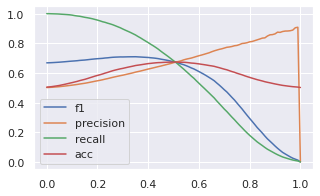

In [ ]:
plt.rcParams["figure.figsize"] = (5,3)
plt.plot(np.linspace(0,1,101),[x[0] for x in list(d.values())],label='f1')
plt.plot(np.linspace(0,1,101),[x[1] for x in list(d.values())],label='precision')
plt.plot(np.linspace(0,1,101),[x[2] for x in list(d.values())],label='recall')
plt.plot(np.linspace(0,1,101),[x[3] for x in list(d.values())],label='acc')
plt.legend()

In [ ]:
matrix = pd.DataFrame(d).T
matrix[matrix[0]==max(matrix[0])][0] #best F1

0.35    0.70876
Name: 0, dtype: float64

In [ ]:
matrix[matrix[3]==max(matrix[3])] # best acc

,0,1,2,3
0.51,0.671169,0.673185,0.669165,0.673087


In [ ]:
# df.to_csv('combined_model.csv')

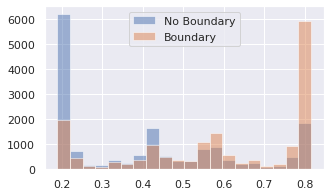

In [ ]:
df2 = df.iloc[train_test_split_index:]
plt.hist(df2[df2['y']==0]['best_pred'],alpha=0.5,label='No Boundary',bins=20,log=False)
plt.hist(df2[df2['y']==1]['best_pred'],alpha=0.5,label='Boundary',bins=20,log=False)
plt.legend()

(array([38462.,  1629.,  3482., 10106.,  4183.,  5320.,  6369.,  1771.,
          694., 10044.]),
 array([0.18934823, 0.25201833, 0.31468842, 0.37735852, 0.44002862,
        0.50269871, 0.56536881, 0.62803891, 0.690709  , 0.7533791 ,
        0.8160492 ]),
 <a list of 10 Patch objects>)

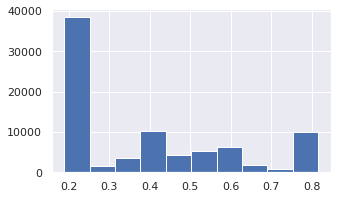

In [ ]:
plt.hist(df[df['y']==0]['best_pred'])

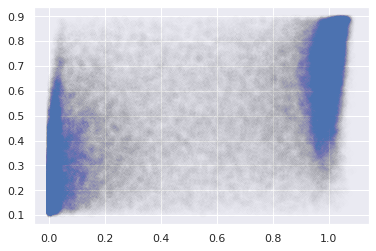

In [ ]:
plt.scatter(agg_pred,df['postboundary_rnn_preds'],alpha=0.005)

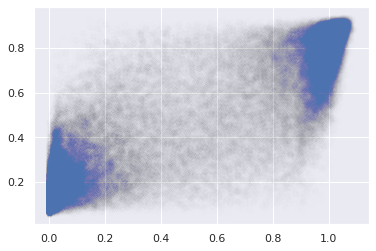

In [ ]:
plt.scatter(agg_pred,df['boundary_cnn_preds'],alpha=0.005)

# Testing!

In [ ]:
init_path = 'drive/Shareddrives/Ling Thesis/resampled/'
fs = os.listdir(init_path)
fs = [init_path + x for x in fs]

In [ ]:
text_path = 'drive/Shareddrives/Rezonator Data/SBCSAE/'

In [ ]:
def get_boundaries(fpath):
  with open(fpath) as f:
    t = f.read()
  a = t.split('\x15')
  IUs = [x for i,x in enumerate(a) if i%2==1]
  boundaries = [x.split('_') for x in IUs]
  a = []
  for b in boundaries:
    a.append(int(b[0]))
    a.append(int(b[1]))

  boundaries = sorted(list(set(a)))
  boundaries = (np.array(boundaries))/1000
  return boundaries

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def append_feats(t_b):
  R_1 = MFCC[:,int(np.floor((t_b-20000)/32)):int(np.floor((t_b)/32))]
  R_2 = MFCC[:,int(np.floor((t_b)/32)):int(np.floor((t_b+20000)/32))]
  R_3 = MFCC[:,int(np.floor(t_b/32))-156:int(np.floor(t_b/32))+156]

  X_preboundary.append(R_1)
  X_postboundary.append(R_2[:,::-1])
  X_boundary.append(R_3)

In [ ]:
X_preboundary = []
X_postboundary = []
X_boundary = []
# X_meta = []
y = []


for file_index,f in enumerate(fs[:2]):
  print(f'{file_index}: {f}')

  # print('\tresample')
  # audio_array, s = librosa.load(f, sr=8000)

  

  # tt = re.findall(r'\d+', f)[0][-2:]
  # with open(f'drive/Shareddrives/Ling Thesis/resampled/{tt}_8k.pickle', 'wb') as handle:
  #   pickle.dump(audio_array, handle, protocol=pickle.HIGHEST_PROTOCOL)

  with open(f, 'rb') as handle:
    audio_array = pickle.load(handle)
  l = len(audio_array)
  tt = f.split('/')[-1].split('_')[0]
  txt = text_path + tt +'.cha'
  boundaries = get_boundaries(txt)
  all_true_bounds = []
  all_pred_bounds = []
  potential_bounds = []

  # ser = moving_average(np.abs(audio_array),300)[::100]
  # for j,x in enumerate(ser):
  #   if (j>1)&(j<len(ser)-2):
  #     if (x<ser[j-1]<ser[j-2]) & (x<ser[j+1]<ser[j+2]):
  #       potential_bounds.append(j)
  #     elif (x < .003):
  #       potential_bounds.append(j)

  # potential_bounds = np.array(potential_bounds)
  # m_index = []
  # for j,v in enumerate(potential_bounds):
  #   try:
  #     if v - potential_bounds[j-1] == 1:
  #       if potential_bounds[j+1]-v == 1:
  #         m_index.append(j)
  #   except IndexError:
  #     pass

  adj_bounds = np.array([x for x in (boundaries*8000)])
  # mask = np.ones(len(potential_bounds), dtype=bool)
  # mask[m_index] = False
  # potential_bounds = (potential_bounds[mask,...]*100)+150
  potential_bounds = np.arange(0,l,100)
  correct = []

  for b in adj_bounds:
    diff = np.abs(potential_bounds-b)
    if np.min(diff) < 100:
      correct.append(potential_bounds[np.argmin(diff)])

  all_true_bounds += list(set(correct))
  all_pred_bounds += [x for x in list(set(potential_bounds)) if x not in correct]

  print('\tgen_MFCC')
  MFCC = librosa.feature.mfcc(audio_array, n_mfcc = 15, hop_length=32)

  MFCC = ((MFCC.T-MFCC.mean(axis=1))/MFCC.std(axis=1)).T
  abs_array = np.abs(audio_array)
  
  print('\tappend feats/labs')
  for k, t_b in enumerate(all_true_bounds):
    if (t_b > 20000)&(t_b+20000<l):
      append_feats(t_b)
      y.append(1)

  for k, p_b in enumerate(all_pred_bounds):
    if (p_b > 20000)&(p_b+20000<l):
      append_feats(p_b)
      y.append(0)

  X_preboundary = np.array(X_preboundary)
  X_postboundary = np.array(X_postboundary)
  X_boundary = np.array(X_boundary)
  y = np.array(y)
  break

0: drive/Shareddrives/Ling Thesis/resampled/32_8k.pickle
	gen_MFCC
	append feats/labs


In [ ]:
len(adj_bounds)

2020

In [ ]:
len(potential_bounds)

133362

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
preboundary_rnn_model = tf.keras.models.load_model('drive/Shareddrives/Ling Thesis/rnn_checkpoints_preboundary/preboundary_rnn-025-0.347673-0.353432.h5')
preboundary_cnn_model = tf.keras.models.load_model('drive/Shareddrives/Ling Thesis/cnn_checkpoints_preboundary_wider/preboundary_cnn-150-0.316627-0.342276.h5')
postboundary_rnn_model = tf.keras.models.load_model('drive/Shareddrives/Ling Thesis/rnn_checkpoints_postboundary/postboundary_rnn-019-0.390455-0.397094.h5')
postboundary_cnn_model = tf.keras.models.load_model('drive/Shareddrives/Ling Thesis/cnn_checkpoints_postboundary_wider/postboundary_cnn-142-0.327804-0.364012.h5')
boundary_cnn_model = tf.keras.models.load_model('drive/Shareddrives/Ling Thesis/cnn_checkpoints_boundary_wider/boundary_cnn-126-0.316480-0.329793.h5')

In [ ]:
X_preboundary = X_preboundary.transpose(0,2,1)
X_postboundary = X_postboundary.transpose(0,2,1)
X_boundary = X_boundary.transpose(0,2,1)

In [ ]:
df.columns

Index(['preboundary_rnn_preds', 'preboundary_cnn_preds',
       'postboundary_rnn_preds', 'postboundary_cnn_preds',
       'boundary_cnn_preds', 'y'],
      dtype='object')

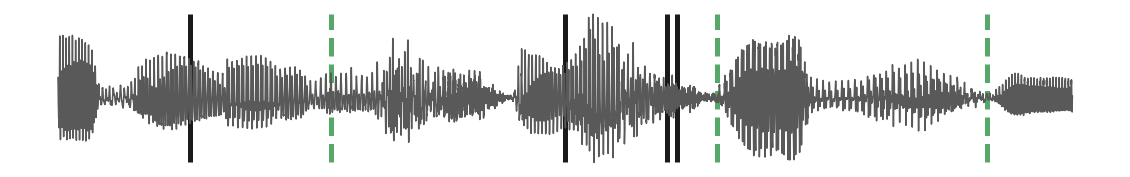

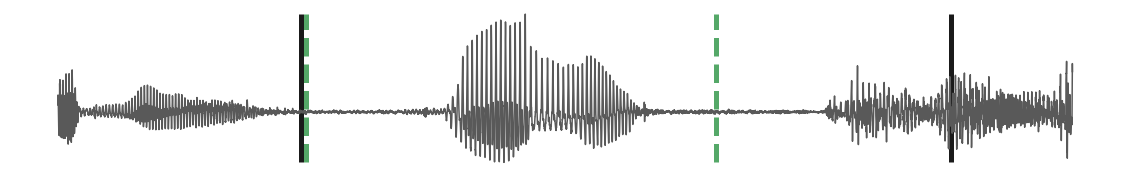

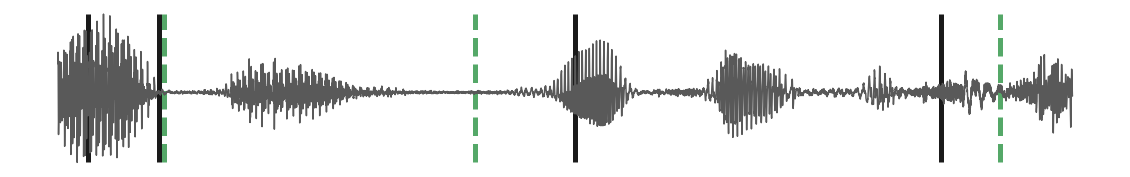

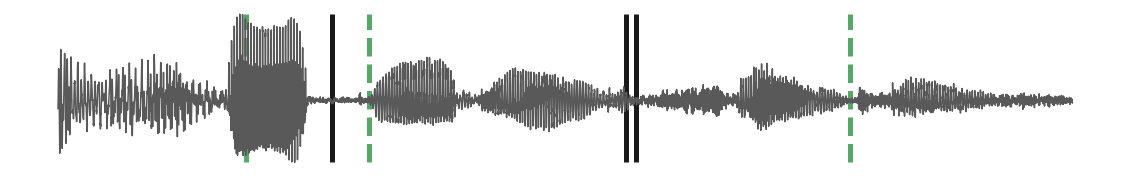

In [ ]:
n = 10000
plt.rcParams["figure.figsize"] = (20,3)
potential_bounds = potential_bounds[(potential_bounds+20000<l)&(potential_bounds>20000)]
adj_bounds = adj_bounds[(adj_bounds+20000<l)&(adj_bounds>20000)]



for i in range(4,8):
  
  pred_df = pd.DataFrame()
  vals = audio_array[n*i:n*(i+1)]
  mask = (potential_bounds<n*(i+1))&(potential_bounds>n*(i))
  # plt.vlines(potential_bounds[mask],np.min(vals),np.max(vals),color='pink',linewidth=5.0)

  pred_df['pre_rnn_scores'] = np.array([x[0] for x in preboundary_rnn_model.predict(X_preboundary[mask])])
  pred_df['post_rnn_scores'] = np.array([x[0] for x in postboundary_rnn_model.predict(X_postboundary[mask])])
  # pred_df['b_rnn_scores'] = np.array([x[0] for x in boundary_rnn_model.predict(X_boundary[mask])])

  pred_df['pre_cnn_scores'] = np.array([x[0] for x in preboundary_cnn_model.predict(X_preboundary[mask][:,-100:])])
  pred_df['post_cnn_scores'] = np.array([x[0] for x in postboundary_cnn_model.predict(X_postboundary[mask][:,-100:])])
  pred_df['b_cnn_scores'] = np.array([x[0] for x in boundyary_cnn_model.predict(X_boundary[mask][:,100:212])])

  
  pred_df = pred_df[['pre_rnn_scores', 'pre_cnn_scores',
       'post_rnn_scores', 'post_cnn_scores', 'b_cnn_scores']]

  pred_df['agg_pred'] = model.predict(pred_df.values)

  mask2 = (pred_df['agg_pred'] > 0.81)
  plt.plot(range(n*i,n*(i+1)),vals,color='#595959')
  plt.vlines(potential_bounds[mask][mask2],np.min(vals),np.max(vals),linewidth=5.0)

  # plt.vlines(adj_bounds[(adj_bounds<n*(i+1))&(adj_bounds>n*(i))],np.min(vals),np.max(vals),color='#00306c',linewidth=5.0)
  plt.vlines(adj_bounds[(adj_bounds<n*(i+1))&(adj_bounds>n*(i))],np.min(vals),np.max(vals),color='g',linewidth=5.0,linestyles='--')

  plt.axis('off')
  plt.show()
  # plt.imshow(MFCC[:,n*i:n*i+75])
  # plt.show()

In [ ]:
potential_bounds[2]-potential_bounds[1]

200

In [ ]:
np.arange(0,100,7)

array([ 0,  7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98])

In [ ]:
(-18.870514, 87.832634)
(-18.78246, 86.658844)

In [ ]:
X_postboundary = ((X_postboundary-(-18.858986))/87.60684).transpose(0,2,1)

In [ ]:
X_preboundary = X_preboundary.transpose(0,2,1)

In [ ]:
scores = np.array([x[0] for x in model.predict(X_preboundary[mask])])

In [ ]:
scores

array([0.8468633 , 0.22352238, 0.09062894, 0.15482011, 0.6424453 ,
       0.6296967 , 0.5690421 , 0.44614846, 0.7057705 , 0.43918863,
       0.5986084 , 0.36538884, 0.42039967, 0.4890924 , 0.5395438 ,
       0.7752204 , 0.42618197, 0.38952297, 0.41430938, 0.59206367,
       0.70648634, 0.536859  , 0.53474283, 0.26269263, 0.37098333,
       0.55192983, 0.28335118, 0.25023642, 0.39470676, 0.45837215,
       0.4017303 , 0.50162435, 0.51122266, 0.56536424, 0.61923295,
       0.7643163 , 0.4738032 , 0.5166149 , 0.5295815 , 0.5640935 ,
       0.60370773, 0.6141053 , 0.5981027 , 0.48835656], dtype=float32)